# Spatial clustering and denoising expressions

STAGATE is designed for spatial clustering and denoising expressions of spatial resolved transcriptomics (ST) data.

STAGATE learns low-dimensional latent embeddings with both spatial information and gene expressions via a graph attention auto-encoder. The method adopts an attention mechanism in the middle layer of the encoder and decoder, which adaptively learns the edge weights of spatial neighbor networks, and further uses them to update the spot representation by collectively aggregating information from its neighbors. The latent embeddings and the reconstructed expression profiles can be used to downstream tasks such as spatial domain identification, visualization, spatial trajectory inference, data denoising and 3D expression domain extraction.

Dong, Kangning, and Shihua Zhang. “Deciphering spatial domains from spatially resolved transcriptomics with an adaptive graph attention auto-encoder.” Nature Communications 13.1 (2022): 1-12.

![fig](https://stagate.readthedocs.io/en/latest/_images/StaGATE_Fig1.png)


In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.6, Tutorials: https://omicverse.readthedocs.io/


## Preprocess data

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

In [ ]:
adata = sc.read_visium(path='data', count_file='151676_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/151676_filtered_feature_bc_matrix.h5


In [ ]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

We read the ground truth area of our spatial data

In [ ]:
# read the annotation
import pandas as pd
import os
Ann_df = pd.read_csv(os.path.join('data', '151676_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [ ]:
adata.obs['X'] = adata.obsm['spatial'][:,0]
adata.obs['Y'] = adata.obsm['spatial'][:,1]

## Training STAGATE model

Here, we used `ov.space.pySTAGATE` to construct a STAGATE object to train the model. 

Because we build the spatial network based on spatial location, our network can be directly divided into subgraphs in the following form.

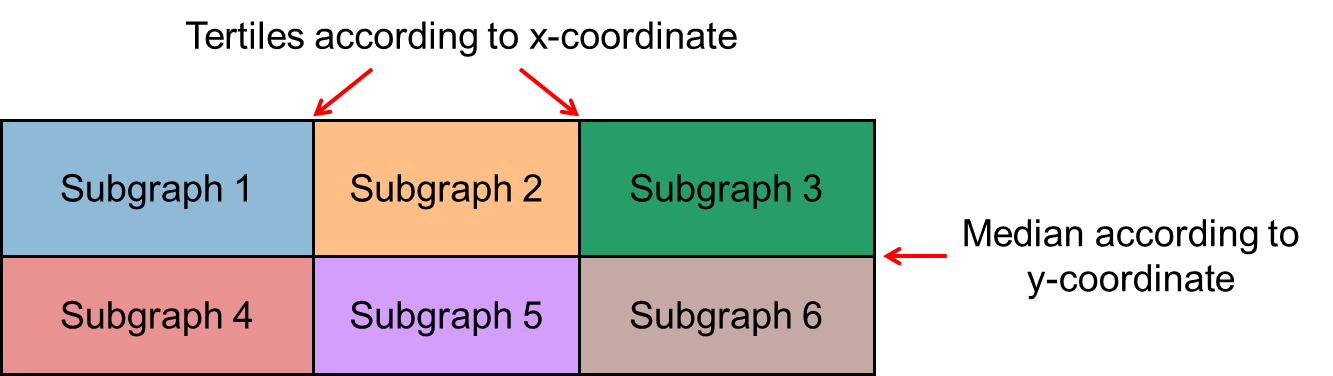

In [ ]:
STA_obj=ov.space.pySTAGATE(adata,num_batch_x=3,num_batch_y=2,
                 spatial_key=['X','Y'],rad_cutoff=200,num_epoch = 1000,lr=0.001,
                weight_decay=1e-4,hidden_dims = [512, 30],
                device='cuda:0')

In [ ]:
STA_obj.train()

We stored the latent embedding in `adata.obsm['STAGATE']`, and denoising expression in `adata.layers['STAGATE_ReX']`

In [8]:
STA_obj.predicted()
adata

AnnData object with n_obs × n_vars = 3460 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Ground Truth', 'X', 'Y'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'spatial', 'log1p', 'hvg', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'
    layers: 'counts', 'STAGATE_ReX'

## Clustering the space

We can use `GMM`, `leiden` or `louvain` to cluster the space.

```python
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='STAGATE')
ov.utils.cluster(adata,use_rep='STAGATE',method='louvain',resolution=1)
ov.utils.cluster(adata,use_rep='STAGATE',method='leiden',resolution=1)
```

In [9]:
ov.utils.cluster(adata,use_rep='STAGATE',method='GMM',n_components=7,covariance_type='full',
                      tol=1e-9, max_iter=1000, random_state=3607)

running GaussianMixture clustering
finished: found 7 clusters and added
    'gmm_cluster', the cluster labels (adata.obs, categorical)


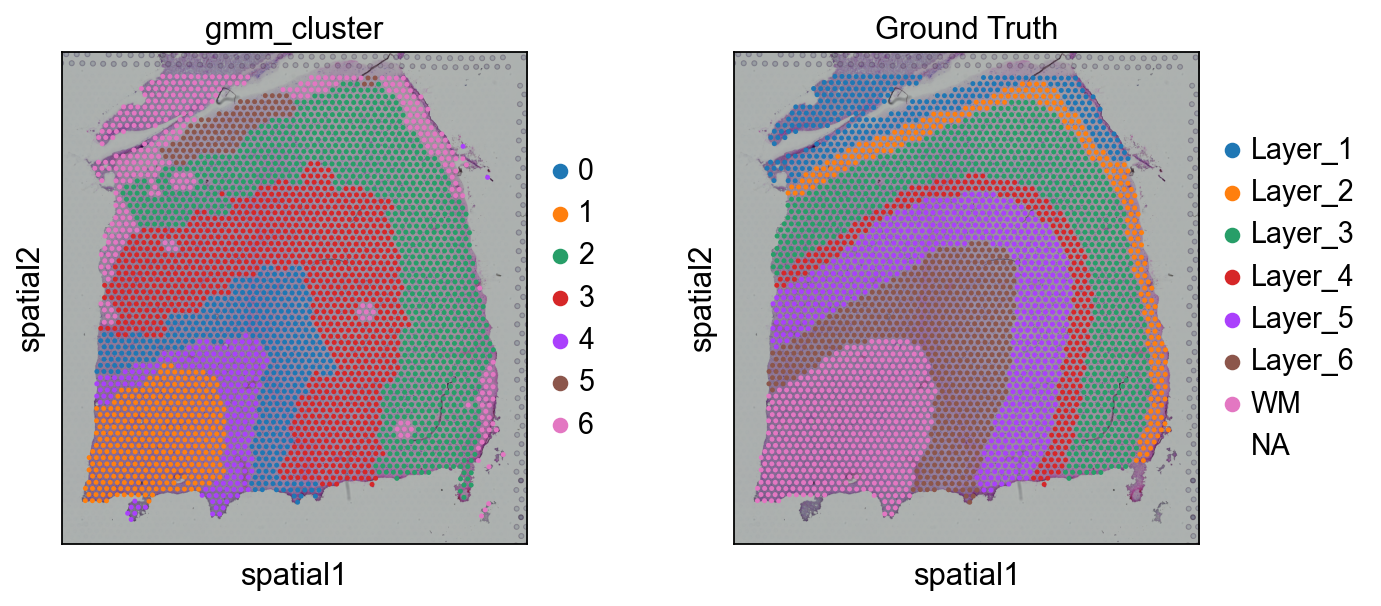

In [16]:
sc.pl.spatial(adata, color=['gmm_cluster',"Ground Truth"])

## Denoising

[<AxesSubplot: title={'center': 'STAGATE_ATP2B4'}, xlabel='spatial1', ylabel='spatial2'>]

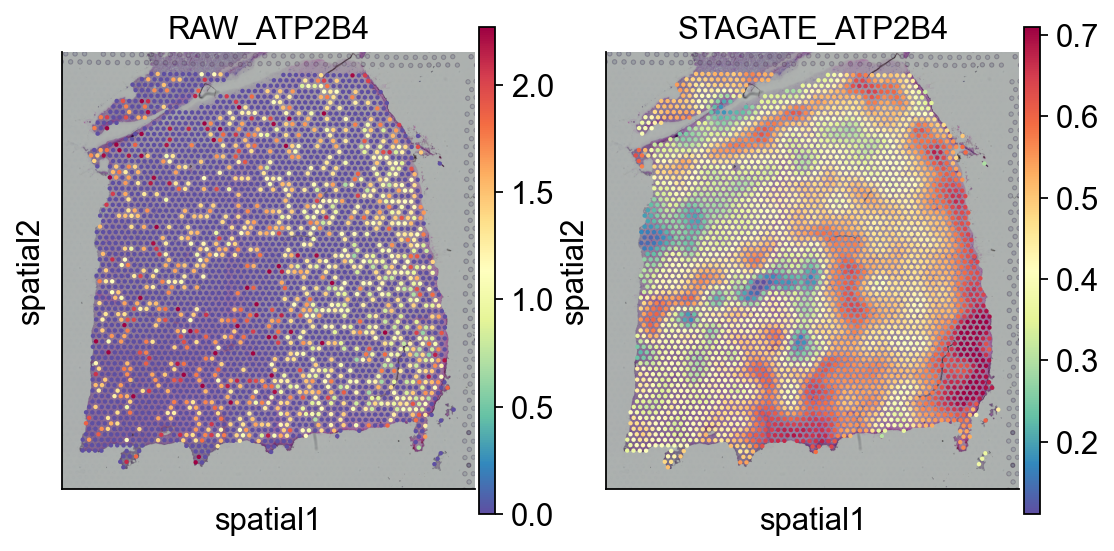

In [10]:
plot_gene = 'ATP2B4'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')


## Calculated the Pseudo-Spatial Map

We compared the model results from `SpaceFlow` and `STAGATE`, and to our surprise, STAGATE can also be applied to predict pSM.

In [11]:
STA_obj.cal_pSM(n_neighbors=20,resolution=1,
                       max_cell_for_subsampling=5000)
adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


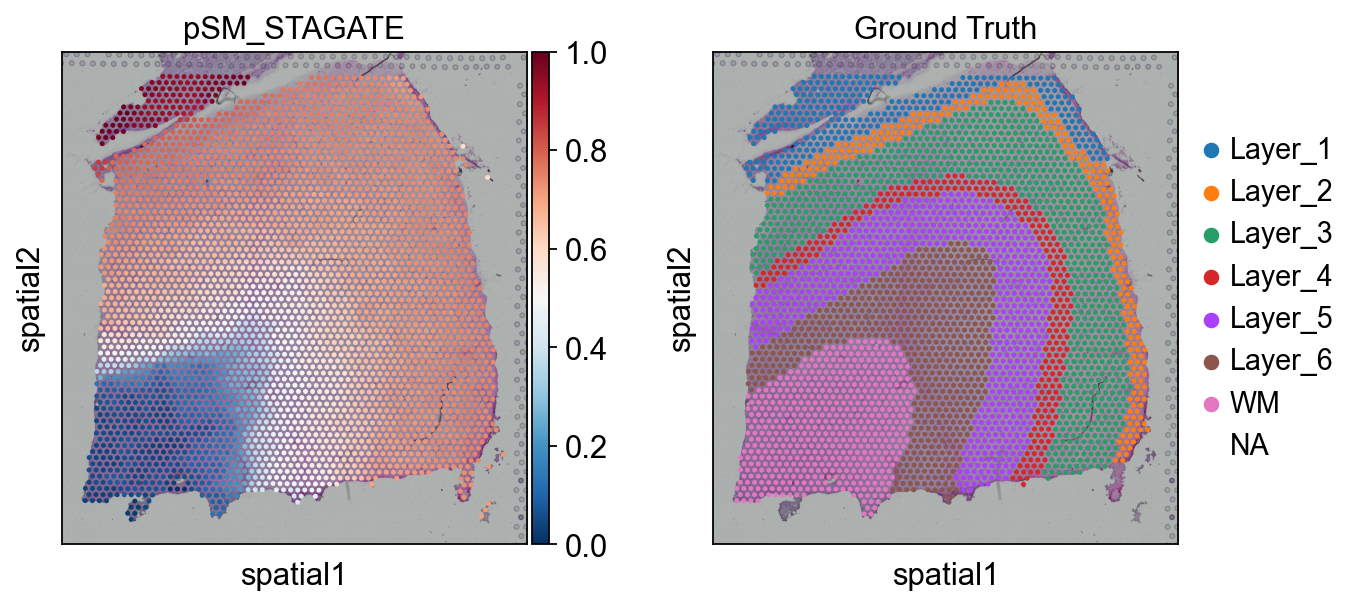

In [14]:
sc.pl.spatial(adata, color=['pSM_STAGATE','Ground Truth'],
             cmap='RdBu_r')